导入包

In [2]:
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.layers import Activation, Add, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Reshape
from sklearn.metrics import roc_curve, auc  
from sklearn.preprocessing import label_binarize  
import matplotlib.pyplot as plt  
import os
import pandas as pd
import librosa
import skimage.util
import config
import pickle
import math
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import numpy as np  
from collections import Counter
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape
from keras.utils import to_categorical  
from tensorflow.keras.models import Sequential  

配置文件和创建文件夹用于存储特征数据

In [28]:
# Configuration file for parameters
# os.getcwd()
# Data directories
# data_df = os.path.join(os.path.pardir, 'data', 'metadata', 'neurips_2021_zenodo_0_0_1.csv')
# data_df = os.path.join(os.path.pardir, 'data', 'metadata', 'db_10_06_21_inc_false_positives.csv')
data_dir = 'humbugdb_neurips_2021'
outputs_dir = os.path.join('outputs')
plot_dir = os.path.join('outputs', 'plots')
model_dir = os.path.join('outputs', 'models')  # Model sub-directory created in config_keras or config_pytorch
# Librosa settings
# Feature output directory
features_dir = os.path.join('outputs', 'features')
# sub-directory for mosquito event_detection
dir_out_MED = os.path.join('outputs', 'features', 'MED')
# sub-directory for mosquito species classification
dir_out_MSC = os.path.join('outputs', 'features', 'MSC')
rate = 8000
win_size = 30
step_size = 5
n_feat = 128
NFFT = 1024
n_hop = NFFT / 2
frame_duration = n_hop / rate  # Frame duration in ms
# Normalisation
norm_per_sample = True
# Calculating window size based on desired min duration (sample chunks)
# default at 8000Hz: 2048 NFFT -> NFFT/4 for window size = hop length in librosa.
# Recommend lowering NFFT to 1024 so that the default hop length is 256 (or 32 ms).
# Then a win size of 60 produces 60x32 = 1.92 (s) chunks for training
min_duration = win_size * frame_duration  # Change to match 1.92 (later)

# Create directories if they do not exist:
for directory in [outputs_dir, features_dir]:
    # 检查路径是否存在，如果不存在则创建
    if not os.path.exists(directory):
        os.makedirs(directory)
        print('Created directory:', directory)


for directory in [plot_dir, dir_out_MED, dir_out_MSC, model_dir]:
    if not os.path.isdir(directory):
        os.mkdir(directory)
        print('Created directory:', directory)


提取特征

In [29]:
df = pd.read_csv('neurips_2021_zenodo_0_0_1.csv')

# To be kept: please do not edit the test set: these paths select test set A, test set B as described in the paper
idx_test_A = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'field')
idx_test_B = np.logical_and(df['country'] == 'UK', df['location_type'] == 'culture')
idx_train = np.logical_not(np.logical_or(idx_test_A, idx_test_B))
df_test_A = df[idx_test_A]
df_test_B = df[idx_test_B]


# Extract features from wave files with id corresponding to dataframe data_df.
def get_feat(data_df, data_dir, rate, min_duration, n_feat):
    ''' Returns features extracted with Librosa. A list of features, with the number of items equal to the number of input recordings'''
    X = []
    y = []
    bugs = []
    idx = 0
    skipped_files = []
    for row_idx_series in data_df.iterrows():
        idx += 1
        if idx % 100 == 0:
            print('Completed', idx, 'of', len(data_df))
        row = row_idx_series[1]
        label_duration = row['length']
        if label_duration > min_duration:
            _, file_format = os.path.splitext(row['name'])
            filename = os.path.join(data_dir, str(row['id']) + file_format)
            length = librosa.get_duration(path=filename)
            #             assert math.isclose(length,label_duration, rel_tol=0.01), "File: %s label duration (%.4f) does not match audio length (%.4f)" % (row['path'], label_duration, length)

            if math.isclose(length, label_duration, rel_tol=0.01):
                signal, rate = librosa.load(filename, sr=rate)
                feat = librosa.feature.melspectrogram(y=signal, sr=rate, n_mels=n_feat)
                feat = librosa.power_to_db(feat, ref=np.max)
                if config.norm_per_sample:
                    feat = (feat - np.mean(feat)) / np.std(feat)
                X.append(feat)
                if row['sound_type'] == 'mosquito':
                    y.append(0)
                else:
                    if row['sound_type'] =='background':  
                        y.append(1)
                    else:
                        y.append(2)
            else:
                print("File: %s label duration (%.4f) does not match audio length (%.4f)" % (
                    row['name'], label_duration, length))
                bugs.append([row['name'], label_duration, length])

        else:
            skipped_files.append([row['id'], row['name'], label_duration])
    return X, y, skipped_files, bugs


def reshape_feat(feats, labels, win_size, step_size):
    '''Reshaping features from get_feat to be compatible for classifiers expecting a 2D slice as input. Parameter `win_size` is
    given in number of feature windows (in librosa this is the hop length divided by the sample rate.)
    Can code to be a function of time and hop length instead in future.'''

    feats_windowed_array = []
    labels_windowed_array = []
    for idx, feat in enumerate(feats):
        if np.shape(feat)[1] < win_size:
            print('Length of recording shorter than supplied window size.')
            pass
        else:
            feats_windowed = skimage.util.view_as_windows(feat.T, (win_size, np.shape(feat)[0]), step=step_size)
            # feats_windowed = np.squeeze(feats_windowed) # 删除多余维度
            labels_windowed = np.full(len(feats_windowed), labels[idx])
            feats_windowed_array.append(feats_windowed)
            labels_windowed_array.append(labels_windowed)
    return np.vstack(feats_windowed_array), np.hstack(labels_windowed_array)


In [30]:

def get_train_test_from_df(df_train, df_test_A, df_test_B, debug=False):
    pickle_name_train = 'log_mel_feat_train_' + str(config.n_feat) + '_win_' + str(config.win_size) + '_step_' + str(
        config.step_size) + '_norm_' + str(config.norm_per_sample) + '.pickle'
    # step = window for test (no augmentation of test):
    pickle_name_test = 'log_mel_feat_test_' + str(config.n_feat) + '_win_' + str(config.win_size) + '_step_' + str(
        config.win_size) + '_norm_' + str(config.norm_per_sample) + '.pickle'

    if not os.path.isfile(os.path.join(config.dir_out_MED, pickle_name_train)):
        print('Extracting training features...')
        X_train, y_train, skipped_files_train, bugs_train = get_feat(data_df=df_train, data_dir=config.data_dir,
                                                                     rate=config.rate, min_duration=config.min_duration,
                                                                     n_feat=config.n_feat)
        X_train, y_train = reshape_feat(X_train, y_train, config.win_size, config.step_size)

        log_mel_feat_train = {'X_train': X_train, 'y_train': y_train, 'bugs_train': bugs_train}

        if debug:
            print('Bugs train', bugs_train)

        with open(os.path.join(config.dir_out_MED, pickle_name_train), 'wb') as f:
            pickle.dump(log_mel_feat_train, f, protocol=4)
            print('Saved features to:', os.path.join(config.dir_out_MED, pickle_name_train))

    else:
        print('Loading training features found at:', os.path.join(config.dir_out_MED, pickle_name_train))
        with open(os.path.join(config.dir_out_MED, pickle_name_train), 'rb') as input_file:
            log_mel_feat = pickle.load(input_file)
            X_train = log_mel_feat['X_train']
            y_train = log_mel_feat['y_train']

    if not os.path.isfile(os.path.join(config.dir_out_MED, pickle_name_test)):
        print('Extracting test features...')

        X_test_A, y_test_A, skipped_files_test_A, bugs_test_A = get_feat(data_df=df_test_A, data_dir=config.data_dir,
                                                                         rate=config.rate,
                                                                         min_duration=config.min_duration,
                                                                         n_feat=config.n_feat)
        X_test_B, y_test_B, skipped_files_test_B, bugs_test_B = get_feat(data_df=df_test_B, data_dir=config.data_dir,
                                                                         rate=config.rate,
                                                                         min_duration=config.min_duration,
                                                                         n_feat=config.n_feat)
        X_test_A, y_test_A = reshape_feat(X_test_A, y_test_A, config.win_size,
                                          config.win_size)  # Test should be strided with step = window.
        X_test_B, y_test_B = reshape_feat(X_test_B, y_test_B, config.win_size, config.win_size)

        log_mel_feat_test = {'X_test_A': X_test_A, 'X_test_B': X_test_B, 'y_test_A': y_test_A, 'y_test_B': y_test_B}

        if debug:
            print('Bugs test A', bugs_test_A)
            print('Bugs test B', bugs_test_B)

        with open(os.path.join(config.dir_out_MED, pickle_name_test), 'wb') as f:
            pickle.dump(log_mel_feat_test, f, protocol=4)
            print('Saved features to:', os.path.join(config.dir_out_MED, pickle_name_test))
    else:
        print('Loading test features found at:', os.path.join(config.dir_out_MED, pickle_name_test))
        with open(os.path.join(config.dir_out_MED, pickle_name_test), 'rb') as input_file:
            log_mel_feat = pickle.load(input_file)

            X_test_A = log_mel_feat['X_test_A']
            y_test_A = log_mel_feat['y_test_A']
            X_test_B = log_mel_feat['X_test_B']
            y_test_B = log_mel_feat['y_test_B']

    return X_train, y_train, X_test_A, y_test_A, X_test_B, y_test_B


df_train = df[idx_train]

# Modify by addition or sub-sampling of df_train here
# df_train ...

# Assertion to check that train does NOT appear in test:
assert len(np.where(pd.concat([df_train, df_test_A, df_test_B]).duplicated())[0]) == 0, (
    'Train dataframe contains overlap with Test A, Test B')


In [31]:

# 获取数据
X_train, y_train, X_test_A, y_test_A, X_test_B, y_test_B = get_train_test_from_df(df_train, df_test_A, df_test_B,
                                                                                  debug=True)

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test_A = np.array(X_test_A)
X_test_B = np.array(X_test_B)
y_test_A = np.array(y_test_A)
y_test_B = np.array(y_test_B)

# Check for NaN values in X_train
nan_indices = np.isnan(X_train)
if np.any(nan_indices):
    print("NaN values found in X_train. Handling NaN values...")
    # Option 1: Replace NaN with mean value
    from sklearn.impute import SimpleImputer

    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)

    # Option 2: Drop samples with NaN values
    # X_train = X_train[~np.any(nan_indices, axis=1)]

Loading training features found at: outputs\features\MED\log_mel_feat_train_128_win_30_step_5_norm_True.pickle
Loading test features found at: outputs\features\MED\log_mel_feat_test_128_win_30_step_30_norm_True.pickle


In [32]:
print(X_train.shape)

(302037, 1, 30, 128)


In [33]:
# 训练集标签分布
print('y_train dataset shape %s' % Counter(y_train))
print('y_test_A dataset shape %s' % Counter(y_test_A))
print('y_test_B dataset shape %s' % Counter(y_test_B))

y_train dataset shape Counter({0: 163603, 1: 136188, 2: 2246})
y_test_A dataset shape Counter({1: 2068, 0: 1714})
y_test_B dataset shape Counter({1: 1019, 0: 616, 2: 65})


整理输入数据

In [34]:
X_train = X_train
y_train = y_train
# 调整张量形状
X_train = np.squeeze(X_train)
n_samples, n_w, n_h = X_train.shape
# 将 y_train 转换为独热编码  
y_train = to_categorical(y_train, num_classes=3)  

In [35]:
# 添加一个维度
X_train = Reshape((n_w,n_h,1))(X_train)

CNN网络

In [82]:
# 定义cnn模型
# 设定输入形状
input_shape = (n_w, n_h, 1)

In [75]:
from tensorflow.keras.callbacks import ModelCheckpoint 
checkpoint_cb = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1,  
                                save_best_only=True, mode='min')  

In [159]:
# 创建模型
model = Sequential()

# 添加卷积层
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))  # 添加最大池化层

# 添加第二个卷积层
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 添加第三个卷积层
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

# 添加第四个卷积层
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(GlobalAveragePooling2D())  # 添加全局平均池化层

# 展平层
# GlobalAveragePooling1D 已经展平输出，所以不需要 Flatten 层

# 全连接层
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))  # 添加50%的Dropout

# 输出层
model.add(Dense(3, activation='softmax'))

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

D:\pml-project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 30, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 15, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 15, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 7, 32, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 7, 32, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 3, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 3, 16, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,835 (190.76 KB)

 Trainable params: 48,835 (190.76 KB)

 Non-trainable params: 0 (0.00 B)

CNN_RET

训练模型和评估，模型

In [123]:
from keras.callbacks import Callback 

class LossHistory(Callback):  
    def on_train_begin(self, logs={}):  
        self.train_losses = []  
        self.val_losses = []  
  
    def on_batch_end(self, batch, logs={}):  
        self.train_losses.append(logs.get('loss'))  
  
    def on_epoch_end(self, epoch, logs={}):  
        self.val_losses.append(logs.get('val_loss'))
  

In [124]:
# 输入测试数据
y_test = y_test_B
X_test = X_test_B

In [125]:
# 将y_test转换成独热编码
y_test = to_categorical(y_test, num_classes=3)

In [126]:
# 调整测试集输入数据形状
X_test = np.squeeze(X_test)
X_test = Reshape((n_w,n_h,1))(X_test)

In [71]:
# # 早停法
# from tensorflow.keras.callbacks import EarlyStopping  
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)  

In [160]:
# 实例化LossHistory回调  
history = LossHistory()  
# 训练

model.fit(X_train,y_train,  epochs=3, batch_size=512, validation_split=0.2,callbacks=[history,checkpoint_cb])
# # 查看每个batch的损失  
# print(history.losses)

Epoch 1/3
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8656 - loss: 0.3155
Epoch 1: val_loss did not improve from 0.24433
472/472 ━━━━━━━━━━━━━━━━━━━━ 59s 121ms/step - accuracy: 0.8657 - loss: 0.3152 - val_accuracy: 0.8911 - val_loss: 0.3088
Epoch 2/3
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9807 - loss: 0.0674
Epoch 2: val_loss did not improve from 0.24433
472/472 ━━━━━━━━━━━━━━━━━━━━ 56s 119ms/step - accuracy: 0.9807 - loss: 0.0674 - val_accuracy: 0.8989 - val_loss: 0.2823
Epoch 3/3
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9828 - loss: 0.0579
Epoch 3: val_loss did not improve from 0.24433
472/472 ━━━━━━━━━━━━━━━━━━━━ 56s 118ms/step - accuracy: 0.9828 - loss: 0.0579 - val_accuracy: 0.8701 - val_loss: 0.3762


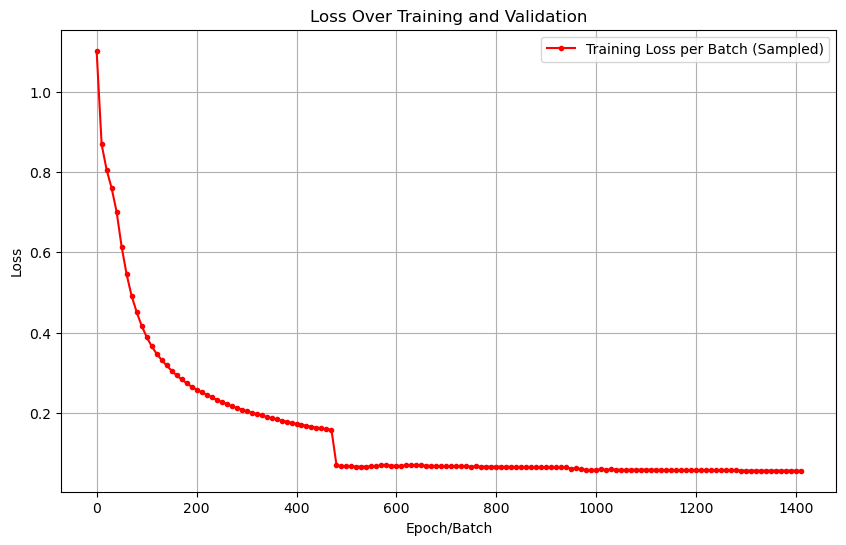

In [161]:
# 绘制损失图 
batch_downsample = 10
plt.figure(figsize=(10, 6))  
plt.plot(range(0, len(history.train_losses), batch_downsample),   
         history.train_losses[::batch_downsample],   
         marker='.', linestyle='-', color='red', label='Training Loss per Batch (Sampled)')  
# plt.plot(range(1, len(history.val_losses) + 1),   
#          history.val_losses,   
#          marker='o', linestyle='-', color='green', label='Validation Loss per Epoch')  
  
plt.title('Loss Over Training and Validation')  
plt.xlabel('Epoch/Batch')  
plt.ylabel('Loss')  
plt.legend()  
plt.grid(True)  
  
plt.show()

In [ ]:
# # 保存模型  
# model.save('last_model.keras')  

In [162]:
# 调整测试集输入数据形状
y_test = y_test_B
# 将独热编码转换为类别标签  
y_test = to_categorical(y_test, num_classes=3)
X_test = X_test_B
# 测试输入整形
# 调整测试集输入数据形状
X_test = np.squeeze(X_test)
X_test = Reshape((n_w,n_h,1))(X_test)


In [165]:
# 评估模型2
loss, accuracy = model.evaluate(X_test, y_test)
print(f"测试损失: {loss}, 测试准确率: {accuracy}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8906 - loss: 0.4512
测试损失: 0.6116853356361389, 测试准确率: 0.8094117641448975


In [166]:
y_pred = model.predict(X_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [167]:
# 将独热编码转换为类别标签  
y_test = np.argmax(y_test, axis=1)  
  
# 将 y_pred 转换成类别标签  

y_pred = np.argmax(y_pred, axis=1) 
  


# 计算每个类别的精确率、召回率和F1分数  
# 注意：sklearn的precision_score, recall_score, f1_score默认计算的是所有类别的平均值  

# 类别标签，用于指定要计算哪些类别的指标  
labels = np.unique(y_test)  

# 计算准确率  
accuracy = accuracy_score(y_test, y_pred)  
print(f"准确率: {accuracy}")

# 计算每个类别的精确率  
precisions = {label: precision_score(y_test, y_pred, average=None, labels=[label]) for label in labels}  
  
# 计算每个类别的召回率  
recalls = {label: recall_score(y_test, y_pred, average=None, labels=[label]) for label in labels}  
  
# 计算每个类别的F1分数  
f1s = {label: f1_score(y_test, y_pred, average=None, labels=[label]) for label in labels}  
  
# 打印结果  
print("精确率:", precisions)  
print("召回率:", recalls)  
print("F1分数:", f1s)  
  
# 如果你想要宏平均（Macro-averaging）或微平均（Micro-averaging）的结果，  
# 可以简单地调用precision_score, recall_score, f1_score时设置average参数为'macro'或'micro'  
macro_precision = precision_score(y_test, y_pred, average='macro')  
macro_recall = recall_score(y_test, y_pred, average='macro')  
macro_f1 = f1_score(y_test, y_pred, average='macro')  
  
print("宏平均精确率:", macro_precision)  
print("宏平均召回率:", macro_recall)  
print("宏平均F1分数:", macro_f1)

# 计算混淆矩阵  
cm = confusion_matrix(y_pred,y_test)  
  
# 打印混淆矩阵  
print("混淆矩阵:")  
print(cm)  



准确率: 0.8094117647058824
精确率: {0: array([0.93083573]), 1: array([0.77046672]), 2: array([1.])}
召回率: {0: array([0.52435065]), 1: array([0.98822375]), 2: array([0.70769231])}
F1分数: {0: array([0.67082035]), 1: array([0.86586414]), 2: array([0.82882883])}
宏平均精确率: 0.9004341508481266
宏平均召回率: 0.7400889019387548
宏平均F1分数: 0.7885044421153903
混淆矩阵:
[[ 323   12   12]
 [ 293 1007    7]
 [   0    0   46]]


In [168]:
# 绘制roc曲线
y_test = y_test_B
# 将独热编码转换为类别标签  
y_test = to_categorical(y_test, num_classes=3)

# 测试输入
y_pred = model.predict(X_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


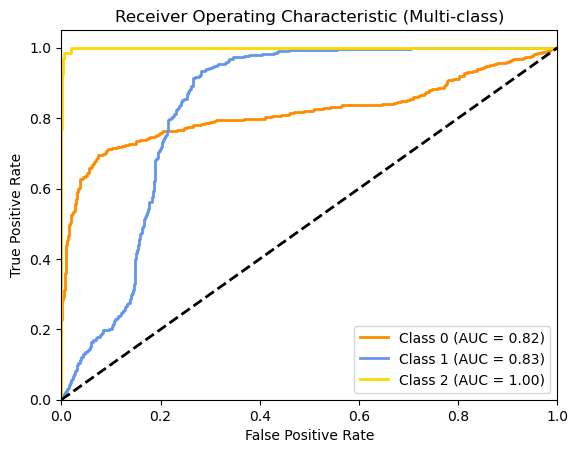

In [169]:
# 将类别标签二值化  
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  
n_classes = y_test_binarized.shape[1]  

# 初始化FPR, TPR数组  
fpr = dict()  
tpr = dict()  
roc_auc = dict()  
  
# 对每个类别计算ROC曲线  
for i in range(n_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])  
    roc_auc[i] = auc(fpr[i], tpr[i])  
  
# 绘制ROC曲线  
plt.figure()  
lw = 2  
colors = ['darkorange', 'cornflowerblue', 'gold']  
for i, color in zip(range(n_classes), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,  
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')  
  
plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Receiver Operating Characteristic (Multi-class)')  
plt.legend(loc="lower right")  
plt.show()

In [ ]:
from keras.preprocessing import sequence
from keras.datasets import imdb
from matplotlib import pyplot as plt
import pandas as pd
  
from keras import backend as K
from keras.engine.topology import Layer
  
  
class Self_Attention(Layer):
  
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Self_Attention, self).__init__(**kwargs)
  
    def build(self, input_shape):
        # 为该层创建一个可训练的权重
        #inputs.shape = (batch_size, time_steps, seq_len)
        self.kernel = self.add_weight(name='kernel',
                                      shape=(3,input_shape[2], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
  
        super(Self_Attention, self).build(input_shape)  # 一定要在最后调用它
  
    def call(self, x):
        WQ = K.dot(x, self.kernel[0])
        WK = K.dot(x, self.kernel[1])
        WV = K.dot(x, self.kernel[2])
  
        print("WQ.shape",WQ.shape)
  
        print("K.permute_dimensions(WK, [0, 2, 1]).shape",K.permute_dimensions(WK, [0, 2, 1]).shape)
  
  
        QK = K.batch_dot(WQ,K.permute_dimensions(WK, [0, 2, 1]))
  
        QK = QK / (64**0.5)
  
        QK = K.softmax(QK)
  
        print("QK.shape",QK.shape)
  
        V = K.batch_dot(QK,WV)
  
        return V
  
    def compute_output_shape(self, input_shape):
  
        return (input_shape[0],input_shape[1],self.output_dim)